In [156]:
import nose.tools
import io
import requests
import numpy as np
import pandas as pd
import math
import json
from urllib.request import urlopen
from scipy import stats


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## About Dataset

#### Context

Understanding what will be the Burn Rate for the employee working in an organization based on the current pandemic situation where work from home is a boon and a bane. How are employees' Burn Rate affected based on various conditions provided?

###  Content
Globally, World Mental Health Day is celebrated on October 10 each year. The objective of this day is to raise awareness about mental health issues around the world and mobilize efforts in support of mental health. According to an anonymous survey, about 450 million people live with mental disorders that can be one of the primary causes of poor health and disability worldwide. These days when the world is suffering from a pandemic situation, it becomes really hard to maintain mental fitness.

Employee ID: The unique ID allocated for each employee (example: fffe390032003000)

Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)

Gender: The gender of the employee (Male/Female)

Company Type: The type of company where the employee is working (Service/Product)

WFH Setup Available: Is the work from home facility available for the employee (Yes/No)

Designation: The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.

Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours.
In the range of [1.0, 10.0] (higher means more resource)

Mental Fatigue Score: The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.

Burn Rate: The value we need to predict for each employee telling the rate of Bur out while working.
In the range of [0.0, 1.0] where the higher the value is more is the burn out.

### Inspiration 
Try to build some really amazing predictions keeping in mind that happy and healthy employees are indisputably more productive at work, and in turn, help the business flourish profoundly.

In [112]:
employes_data = pd.read_csv("data\employes_2008.csv")
employes_data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [113]:
column_names = ["employee_id","date","gender","company_type","home_office","designation","working_time","fatigue","burn_rate"]
employes_data.columns = column_names
employes_data.index = employes_data["employee_id"]
employes_data.drop("employee_id", axis=1, inplace= True)
employes_data.head()

,date,gender,company_type,home_office,designation,working_time,fatigue,burn_rate
employee_id,,,,,,,,
fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [114]:
employes_data.dtypes

date             object
gender           object
company_type     object
home_office      object
designation     float64
working_time    float64
fatigue         float64
burn_rate       float64
dtype: object

In [115]:
employes_data.shape

(22750, 8)

In [116]:
employes_data.isnull().sum()

date               0
gender             0
company_type       0
home_office        0
designation        0
working_time    1381
fatigue         2117
burn_rate       1124
dtype: int64

In [118]:
employes_data.dropna(subset = ["fatigue"], inplace= True)
employes_data.dropna(subset = ["burn_rate"], inplace= True)
employes_data.isnull().sum()

date               0
gender             0
company_type       0
home_office        0
designation        0
working_time    1091
fatigue            0
burn_rate          0
dtype: int64

In [119]:
employes_data.shape

(19681, 8)

In [120]:
employes_data[["gender", "working_time"]].groupby("gender").agg("mean")

,working_time
gender,
Female,4.211757
Male,4.789438


In [121]:
mean_working_time = math.ceil(employes_data["working_time"].mean())
mean_working_time

5

In [122]:
employes_data['working_time'] = employes_data['working_time'].fillna(mean_working_time)
employes_data['working_time'].unique()

array([ 3.,  2.,  5.,  1.,  7.,  4.,  6.,  8., 10.,  9.])

In [123]:
def calculate_correlation(dataframe, first_column, second_column):
    correlation = dataframe[first_column].corr(dataframe[first_column])
    return correlation

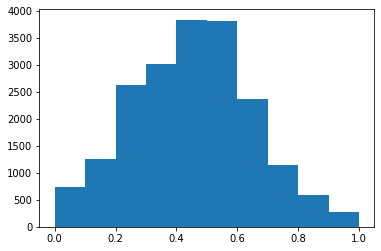

In [125]:
plt.hist(employes_data.burn_rate)
plt.show()

TypeError: 'str' object is not callable

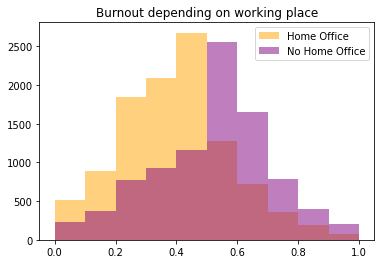

In [152]:
hf = employes_data[(employes_data["home_office"] == "Yes")]
nohf = employes_data[(employes_data["home_office"] == "No")]

plt.hist(hf["burn_rate"], alpha= .5,label = "Home Office", color = "orange")
plt.hist(nohf["burn_rate"], alpha= .5,label = "No Home Office", color = "purple")
plt.legend(loc="upper right")
plt.title("Burnout depending on working place")
# plt.xlabel("Number of people", labelpad = 5)
# plt.ylabel("Burnout Coefficient", labelpad = 5)
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.show()

In [157]:
stats.ttest_ind(hf["burn_rate"],nohf["burn_rate"])

Ttest_indResult(statistic=-45.07555571377045, pvalue=0.0)

This test checking if Burnrate depends on working place (home office or no home office). From the analysis above, working place dosn't imapct Burn out rate of the employees. 

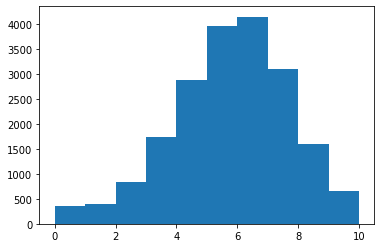

In [126]:
plt.hist(employes_data.fatigue)
plt.show()

Text(0, 0.5, 'Count')

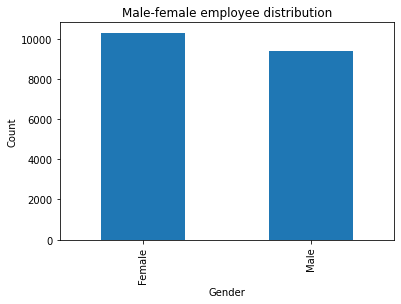

In [163]:
count_gender = employes_data['gender'].value_counts().plot(kind='bar',
                                    title="Male-female employee distribution")
count_gender.set_xlabel("Gender")
count_gender.set_ylabel("Count")

In [165]:
employes_data["gender"].value_counts()

Female    10309
Male       9372
Name: gender, dtype: int64

In [169]:
len(employes_data[employes_data["gender"] == "Male"])/len(employes_data[employes_data["gender"] == "Female"])

0.9091085459307401

Although the gap is quite tiny, there are more female employees than male employees. The ratio of men to women is 0.91. Accordingly, there are 0.91 men for every single female.

Text(0, 0.5, 'Count')

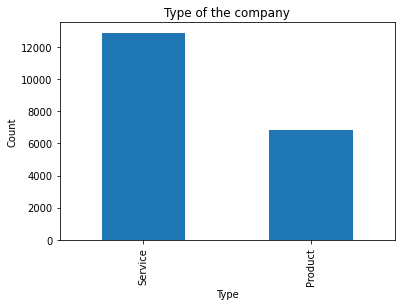

In [170]:
count_gender = employes_data['company_type'].value_counts().plot(kind='bar',
                                    title="Type of the company")
count_gender.set_xlabel("Type")
count_gender.set_ylabel("Count")

In [171]:
employes_data["company_type"].value_counts()

Service    12872
Product     6809
Name: company_type, dtype: int64

In [173]:
len(employes_data[employes_data["company_type"] == "Service"])/len(employes_data[employes_data["company_type"] == "Product"])

1.890439124687913

The two business types are service and product. Nearly twice as many people work for service-type companies as for product-type businesses.